In [1]:
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["XLA_FLAGS"] = "--xla_disable_hlo_passes=custom-kernel-fusion-rewriter" # necessary for V100
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

from alphafold3.model import model, params, features
import jax
from pathlib import Path
import haiku as hk
from jax import numpy as jnp
import functools

config = model.Model.Config()
config.global_config.flash_attention_implementation = 'xla'
config.num_recycles = 0
config.heads.diffusion.eval.num_samples = 50

device = jax.devices("gpu")[0]

In [ ]:
import pandas as pd
df = pd.read_csv("../../boltz_results_final/results_test.csv")
subset = df[df['metric'].str.startswith('dockq') & df['oracle'].notna()]
subset['oracle_minus_average'] = subset['oracle'] - subset['average']
subset_sorted = subset.sort_values(by='oracle_minus_average', ascending=False)
subset_sorted[:20]

In [ ]:
import re
import json
import glob
from alphafold3.data import msa
from alphafold3.constants import mmcif_names
import string

code = "7yuj"

pattern = f"/home/gridsan/jroney/solab/af3/boltz_results_final/inputs/test/af3/msa/{code}*"

msa_files = [file for file in glob.glob(pattern)]
query = json.load(open(f"../../boltz_results_final/inputs/test/af3/queries/{code}.json",'r'))

def replace_paths_in_json(obj, reference_paths):
    # Map basenames to full reference paths
    basename_to_ref = {os.path.basename(p): p for p in reference_paths}

    if isinstance(obj, dict):
        return {k: replace_paths_in_json(v, reference_paths) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [replace_paths_in_json(item, reference_paths) for item in obj]
    elif isinstance(obj, str):
        base = os.path.basename(obj)
        return basename_to_ref.get(base, obj)
    else:
        return obj
        
query = replace_paths_in_json(query, msa_files)

idseq = string.ascii_uppercase
idnum = 0
seqlen = 0
for chainset in query['sequences']:
    for k,v in chainset.items():
        if k == 'rna':
            del chainset[k]['pairedMsa']
        if k == 'protein' and len(v['pairedMsaPath']) == 0:
            v['pairedMsa'] = msa.Msa.from_empty(query_sequence=v['sequence'], chain_poly_type=mmcif_names.PROTEIN_CHAIN).to_a3m()
            del v['pairedMsaPath']
            
        if 'sequence' in v:
            seqlen += len(v['sequence'])*len(v['id'])
        v['id'] = [idseq[idnum+i] for i,s in enumerate(v['id'])]
        idnum += len(v['id'])

print(seqlen)
query

In [ ]:
from alphafold3.common import folding_input
from alphafold3.data import featurisation, pipeline
from alphafold3.constants import chemical_components
from alphafold3.model.components import utils
import json

fold_input = folding_input.Input.from_json(json.dumps(query))

ccd = chemical_components.cached_ccd(user_ccd=fold_input.user_ccd)

featurized_input = featurisation.featurise_input(
  fold_input=fold_input,
  buckets=[seqlen+15],
  ccd=ccd,
  msa_crop_size=4,
  verbose=True,
)[0]

jax_input = jax.device_put(jax.tree_util.tree_map(jnp.asarray, utils.remove_invalidly_typed_feats(featurized_input)), device)

In [2]:
import numpy as np

par = params.get_model_haiku_params(model_dir=Path("../../"))
model_fun = jax.jit(hk.transform(lambda x : model.Model(config)(x)).apply)

key = jax.random.PRNGKey(0)

out =  jax.tree.map(np.asarray, model_fun(par, key, jax_input))

NameError: name 'params' is not defined

In [1]:
out['__identifier__'] = par['__meta__']['__identifier__'].tobytes()
parsed = [x for x in  model.Model.get_inference_result(featurized_input, out)]

NameError: name 'par' is not defined

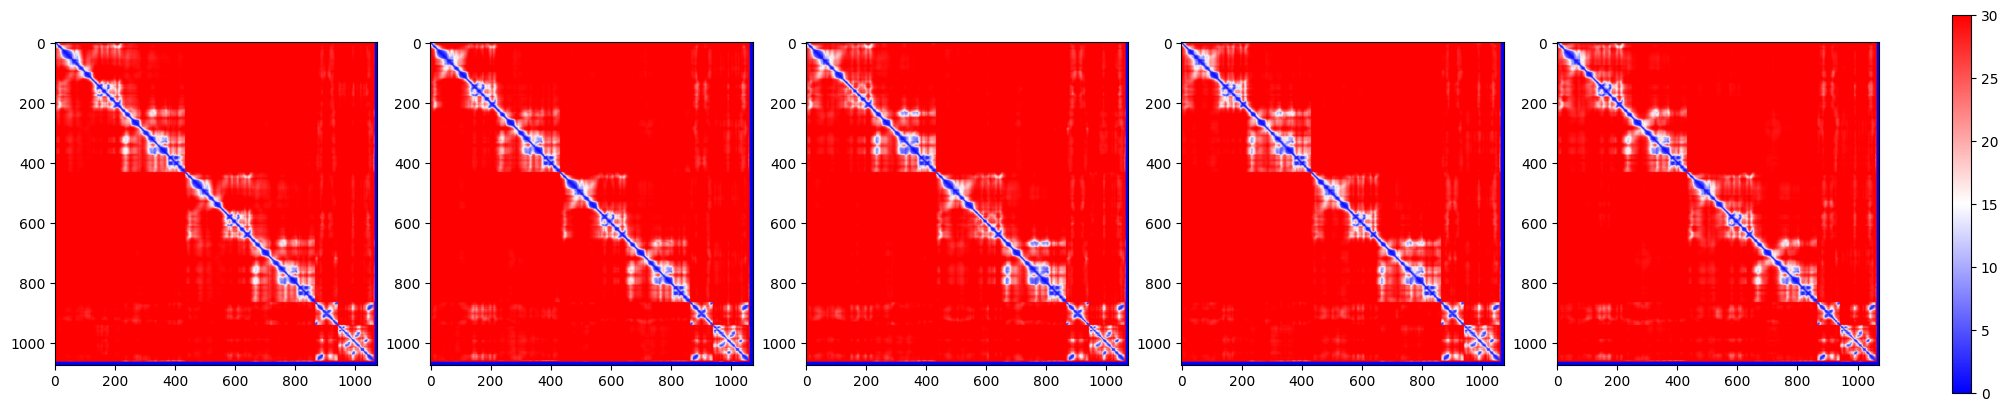

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

num_samples = 5
increments = sorted([(i,p.metadata['iptm']) for i,p in enumerate(parsed)], key=lambda x: x[1])[::len(parsed)//num_samples]

fig, ax = plt.subplots(1, num_samples, figsize=(4*num_samples, 4), constrained_layout=True)
norm = plt.Normalize(0, 30)

for i, a in enumerate(ax):
    im = a.imshow(out["full_pae"][increments[i][0]], cmap="bwr", norm=norm)

fig.colorbar(im, ax=ax, orientation="vertical", fraction=0.02, pad=0.04)
plt.show()

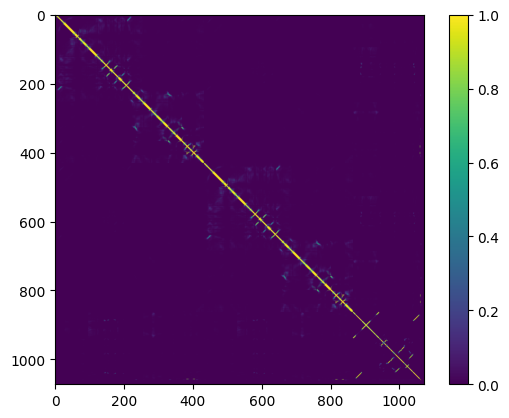

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(out['distogram']['contact_probs'], vmin=0, vmax=1)
plt.colorbar()

/tmp/ipykernel_3764545/6154444.py:3: RuntimeWarning: invalid value encountered in divide
  atom_means = (out['diffusion_samples']['atom_positions'] * out['diffusion_samples']['mask'][..., np.newaxis]).sum(axis=-2) / out['diffusion_samples']['mask'][..., np.newaxis].sum(axis=-2)


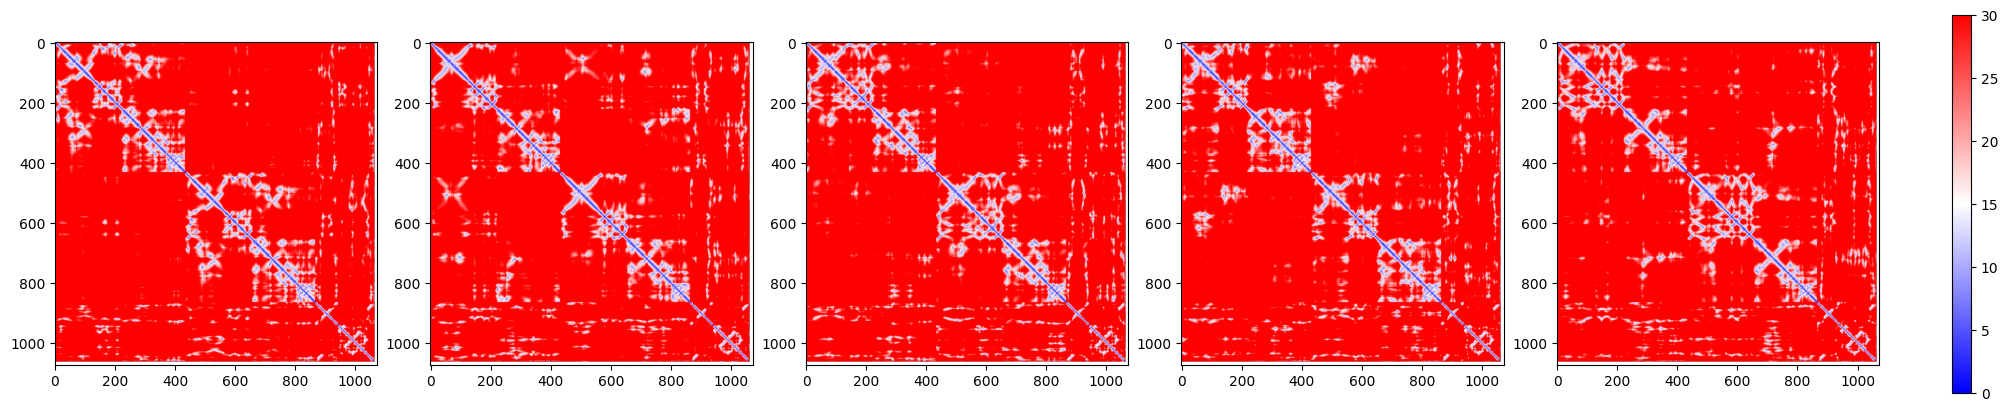

In [9]:
import numpy as np

atom_means = (out['diffusion_samples']['atom_positions'] * out['diffusion_samples']['mask'][..., np.newaxis]).sum(axis=-2) / out['diffusion_samples']['mask'][..., np.newaxis].sum(axis=-2)
dvecs = atom_means[:,np.newaxis,:] - atom_means[:,:,np.newaxis]
dists = np.sqrt((dvecs*dvecs).sum(axis=-1))

fig, ax = plt.subplots(1, num_samples, figsize=(4*num_samples, 4), constrained_layout=True)
norm = plt.Normalize(0, 30)

for i, a in enumerate(ax):
    im = a.imshow(dists[increments[i][0]], cmap="bwr", norm=norm)

fig.colorbar(im, ax=ax, orientation="vertical", fraction=0.02, pad=0.04)
plt.show()

In [10]:
for i,iptm in enumerate(increments):
    with open(f"{code}_{i}.mmcif",'w') as f:
        f.write(parsed[i].predicted_structure.to_mmcif())

In [11]:
iptm_sorted = np.array(sorted([p.metadata['iptm'] for p in parsed]))
print(iptm_sorted)

[0.15850378 0.16056238 0.16260621 0.16261116 0.1627087  0.16328954
 0.16387681 0.16566475 0.16645552 0.16849531]


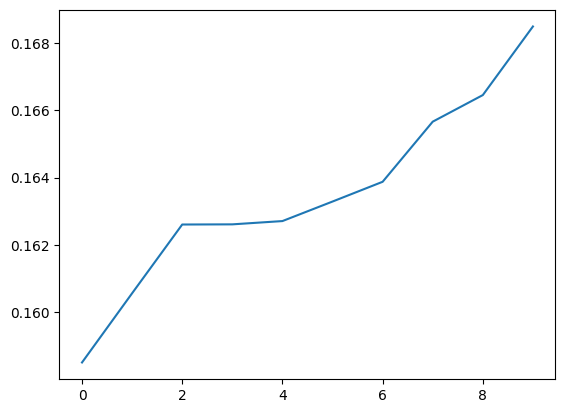

In [12]:
plt.plot(iptm_sorted)